<h3><strong>Ship Classification Using Satellite Images with Deep Transfer Learning Model with Resnet50 Base Architecture</strong></h3><br>
<strong>Author:</strong> Mesuga, Reymond R. <br>
<strong>Contacts:</strong> <a href="https://github.com/Rey-commits">GitHub</a> | <a href="https://www.linkedin.com/in/reymond-r-21410/">LinkIn</a> | <a href="https://www.facebook.com/reymond.mesugah">Facebook</a>

![](https://i.imgur.com/tLsSoTz.png)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import cv2
import imutils as imutils
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # machine learning
from tqdm import tqdm # make your loops show a smart progress meter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

RANDOM_SEED = 42
IMG_SIZE = (80,80)
IMG_PATH = "/content/drive/MyDrive/Personal-Project-Datasets/shipnet_splitted_dataset"

In [3]:
Test_Path = IMG_PATH + "/test/"
Training_Path = IMG_PATH + "/train/"
Validation_Path = IMG_PATH + "/val/"
os.listdir(Test_Path)

['ship', 'no-ship']

In [4]:
def number_of_imgs(path):
  print(path)
  for value in os.listdir(path):
    print(value, "has", len(os.listdir(path + value)), "img")
    print("\n")

number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

/content/drive/MyDrive/Personal-Project-Datasets/shipnet_splitted_dataset/test/
ship has 100 img


no-ship has 300 img


/content/drive/MyDrive/Personal-Project-Datasets/shipnet_splitted_dataset/train/
ship has 800 img


no-ship has 2400 img


/content/drive/MyDrive/Personal-Project-Datasets/shipnet_splitted_dataset/val/
ship has 100 img


no-ship has 300 img




In [5]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if ship then set it to 1 else 0
            ship = 1 if value == "ship" else 0
            data.append({"path": file_path, 'ship': ship})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

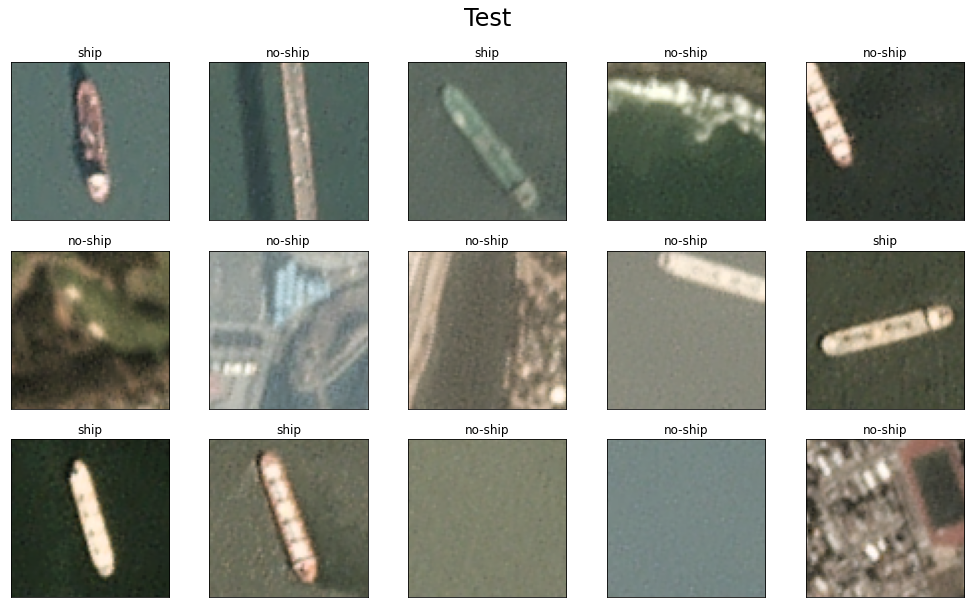

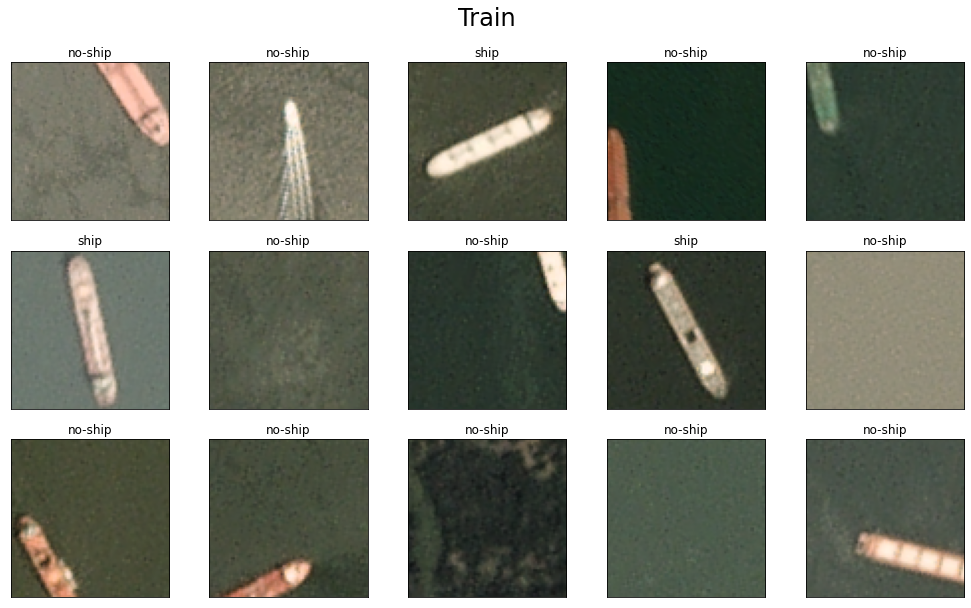

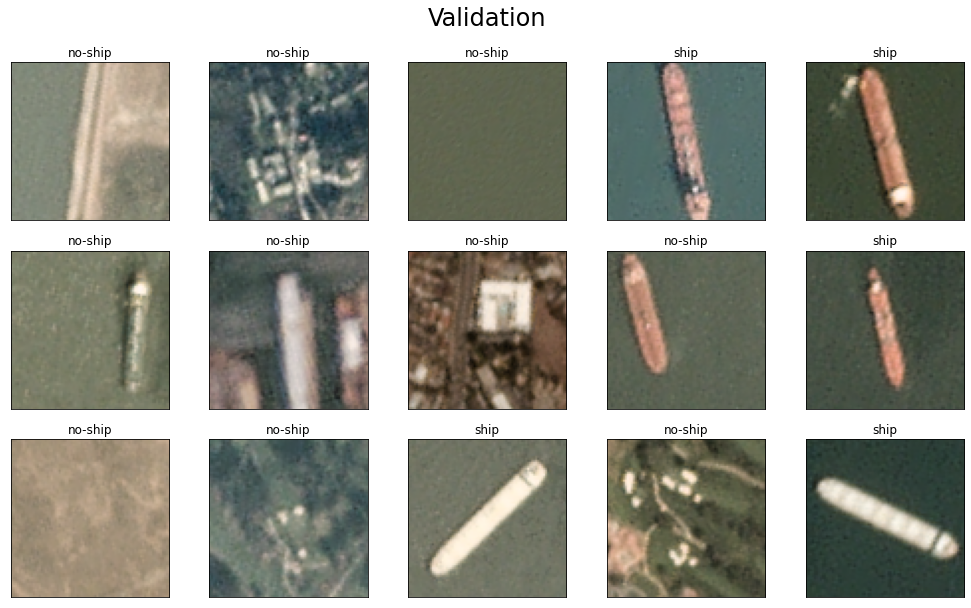

In [6]:
% matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'ship' if row['ship'] == 1 else 'no-ship'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

As observed on the images, the images that are classified as `ship` should contain a whole portion of a ship. If the ship on the image has an incomplete portion then it will be classified as `no-ship`. 

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    Training_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=14,
    class_mode='binary',
    seed=RANDOM_SEED
)
validation_generator = test_datagen.flow_from_directory(
    Validation_Path,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=7,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [8]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 33,034,113
Trainable params: 9,442,305
Non-trainable params: 23,591,808
____________________________________

In [9]:
EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping]
)

print("Training Done")
model.save("Resnet50-Ship-Classification.h5")

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 10s 92ms/step - loss: 1.8982 - accuracy: 0.8847 - val_loss: 0.6653 - val_accuracy: 0.9257
Epoch 2/100
50/50 [==============================] - 3s 54ms/step - loss: 0.1513 - accuracy: 0.9786 - val_loss: 0.0793 - val_accuracy: 0.9886
Epoch 3/100
50/50 [==============================] - 2s 48ms/step - loss: 0.0601 - accuracy: 0.9900 - val_loss: 0.0566 - val_accuracy: 0.9771
Epoch 4/100
50/50 [==============================] - 3s 61ms/step - loss: 0.0758 - accuracy: 0.9856 - val_loss: 0.0877 - val_accuracy: 0.9886
Epoch 5/100
50/50 [==============================] - 2s 47ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0111 - val_accuracy: 0.9886
Epoch 6/100
50/50 [==============================] - 2s 46ms/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.0149 - val_accuracy: 0.9943
Epoch 7/100
50/50 [==============================] - 3s 53ms/step - loss: 0.0088 - accuracy: 0.9957 - val_loss: 0.0123 - val_accuracy: 0.9943
Epoch 8/100
50/50

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [10]:
def preprocess_imgs(path, img_size):
    set_new = []
    for value in os.listdir(path):
        for img in os.listdir(path + value):
            img = cv2.imread(path + value + "/" + img)   
            set_new.append(tf.keras.applications.resnet50.preprocess_input(img))   
    return np.array(set_new)

test_data = preprocess_imgs(Test_Path, img_size=IMG_SIZE)

reality = []
for value in os.listdir(Test_Path):
    for img in os.listdir(Test_Path + value):
        reality.append(1) if value == "no-ship" else reality.append(0)
        
predictions = model.predict(test_data)
predictions = [0 if x > 0.5 else 1 for x in predictions]

accuracy = accuracy_score(reality, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.98


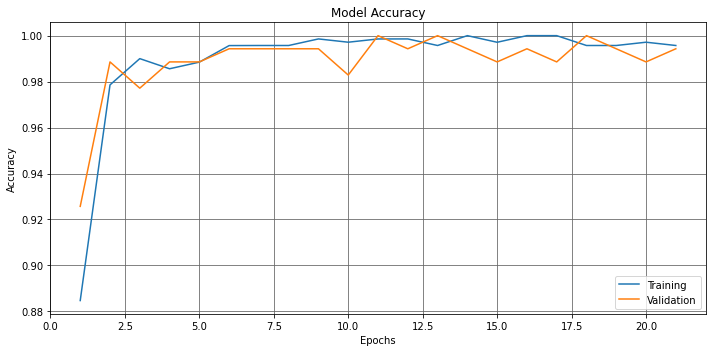

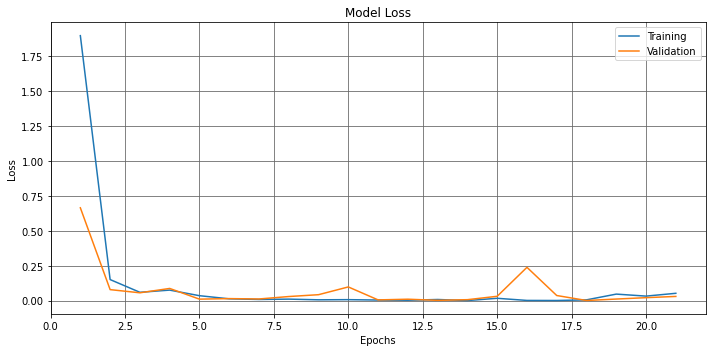

In [11]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

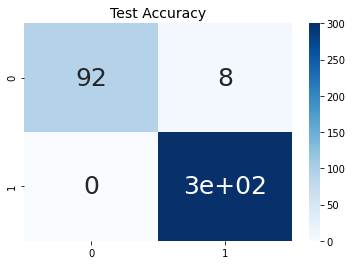

In [12]:
confusion_mtx = confusion_matrix(reality, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax)
ax.set_title('Test Accuracy', size=14)
plt.show()